plot profiles

In [1]:
# python modules
import copy
import re
import random
import numpy as np
import pickle
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
### parameters for plot profiles
domain_param = {}
for domain in ['TSS', 'TSS-TTS']:
    profile_len = 1000
    moving_average_win = 20
    pad_len = moving_average_win/2

    if domain == 'TSS':
        up_win = 2500
        down_win = 5000
        left_len = int(round(up_win*float(profile_len)/(up_win+down_win+1)))
        right_len = profile_len - left_len - 1
        offset = -left_len
        xtick_locs = [-left_len + pad_len, 0, right_len - pad_len]
        xtick_labels = ["-2.5kb", "TSS", "5kb"]


    elif domain == 'TSS-TTS':
        domain_frac = 0.6
        margin_frac = 1.0 - domain_frac
        up_win = 5000
        down_win = 2500
        left_len = int((margin_frac*profile_len)*(float(up_win)/(up_win + down_win)))
        right_len = int((margin_frac*profile_len)*(float(down_win)/(up_win + down_win)))
        offset = -left_len
        xtick_locs = [-left_len+pad_len,
                      0,
                      int(domain_frac*profile_len),
                      int(domain_frac*profile_len) + right_len - pad_len ]
        xtick_labels = ["-5kb", "TSS", "TTS", "2.5kb"]


    param = {}
    param['moving_average_win'] = moving_average_win
    param['profile_len'] = profile_len
    param['up_win'] = up_win
    param['down_win'] = down_win
    param['pad_len'] = pad_len
    param['left_len'] = left_len
    param['right_len'] = right_len
    param['offset'] = offset
    param['xtick_locs'] = xtick_locs
    param['xtick_labels'] = xtick_labels

    if domain == 'TSS-TTS':
        param['domain_frac'] = domain_frac
        param['margin_frac'] = margin_frac

    domain_param[domain] = param
    

In [7]:
### set data information (fname/field) and key
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

dinfo_dkey = {'mCD8T:WT_NCP_sp_1rep_deep_chr([0-9XY])+_score_table_TSS-TTS_profile.txt.gz':
              {'H3K27ac_new_1rep':(1, 'mCD8T:WT', 'H3K27ac'),
               'H3K27ac_new_2rep':(2, 'mCD8T:WT', 'H3K27ac'),
               'H3K27ac_new_3rep':(3, 'mCD8T:WT', 'H3K27ac'),
               'H3K27me3_new_1rep':(1, 'mCD8T:WT', 'H3K27me3'),
               'H3K27me3_new_2rep':(2, 'mCD8T:WT', 'H3K27me3'),
               'H3K27me3_new_3rep':(3, 'mCD8T:WT', 'H3K27me3'),
               'mCD8T:WT_NCP_sp_8_1rep_deep':(1, 'mCD8T:WT', 'score')},
              'mCD8T:DFMO_NCP_sp_1rep_deep_chr([0-9XY])+_score_table_TSS-TTS_profile.txt.gz':
              {'H3K27ac_new_1rep':(1, 'mCD8T:DFMO', 'H3K27ac'),
               'H3K27ac_new_2rep':(2, 'mCD8T:DFMO', 'H3K27ac'),
               'H3K27ac_new_3rep':(3, 'mCD8T:DFMO', 'H3K27ac'),
               'H3K27me3_new_1rep':(1, 'mCD8T:DFMO', 'H3K27me3'),
               'H3K27me3_new_2rep':(2, 'mCD8T:DFMO', 'H3K27me3'),
               'H3K27me3_new_3rep':(3, 'mCD8T:DFMO', 'H3K27me3'),
               'mCD8T:DFMO_NCP_sp_8_1rep_deep':(1, 'mCD8T:DFMO', 'score')},
              'mCD8T:WT_NCP_sp_1rep_deep_chr([0-9XY])+_zscore_table_TSS-TTS_profile.txt.gz':
              {'mCD8T:WT_NCP_sp_8_1rep_deep':(1, 'mCD8T:WT', 'zscore')},
              'mCD8T:DFMO_NCP_sp_1rep_deep_chr([0-9XY])+_zscore_table_TSS-TTS_profile.txt.gz':
              {'mCD8T:DFMO_NCP_sp_8_1rep_deep':(1, 'mCD8T:DFMO', 'zscore')},
              }

In [8]:
### loading profile data
dkey_geneID_profile = {}
for fkey in dinfo_dkey:
    field_dkey = dinfo_dkey[fkey]
    for fname in glob.glob(path + '*'):
        if not re.match(fkey, fname.rsplit('/')[-1]):
            continue
        print "loading %s" % (fname.rsplit('/')[-1])
        field_geneID_profile = load_file.read_profile(fname,
                                                      name_choice=field_dkey.keys())

        for field, dkey in field_dkey.items():
            print "\t %s" % (field)
            geneID_profile = field_geneID_profile[field]
            if dkey not in dkey_geneID_profile:
                dkey_geneID_profile[dkey] = {}
            dkey_geneID_profile[dkey].update(geneID_profile)


loading mCD8T:WT_NCP_sp_1rep_deep_chr10_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr11_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr12_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr13_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr14_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr15_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr16_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr17_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr18_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr19_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr2_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr3_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr4_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr5_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr6_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr7_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr8_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr9_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chrX_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 mCD8T:WT_NCP_sp_8_1rep_deep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr10_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr11_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr12_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr13_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr14_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr15_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr16_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr17_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr18_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr19_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr1_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr2_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr3_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr4_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr5_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr6_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr7_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr8_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chr9_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:WT_NCP_sp_1rep_deep_chrX_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:WT_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr10_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr11_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr12_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr13_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr14_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr15_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr16_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr17_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr18_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr19_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr2_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr3_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr4_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr5_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr6_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr7_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr8_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr9_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chrX_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 mCD8T:DFMO_NCP_sp_8_1rep_deep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr10_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr11_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr12_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr13_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr14_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr15_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr16_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr17_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr18_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr19_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr1_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr2_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr3_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr4_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr5_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr6_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr7_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr8_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chr9_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep
loading mCD8T:DFMO_NCP_sp_1rep_deep_chrX_zscore_table_TSS-TTS_profile.txt.gz


	 mCD8T:DFMO_NCP_sp_8_1rep_deep


In [9]:
### compute profile difference
for dkey in dkey_geneID_profile.keys():
    rep, cell, mark = dkey
    if cell == 'mCD8T:WT':
        continue
    geneID_profile_test = dkey_geneID_profile[dkey]
    geneID_profile_control = dkey_geneID_profile[(rep, 'mCD8T:WT', mark)]
    geneIDs = set(geneID_profile_test.keys()) & set(geneID_profile_control.keys())
    geneID_dprofile = {}
    for geneID in geneIDs:
        dprofile = geneID_profile_test[geneID] - geneID_profile_control[geneID]
        geneID_dprofile[geneID] = dprofile
    dkey_geneID_profile[(rep, cell, 'd'+mark)] = geneID_dprofile
        

In [10]:
### read GTF file
GTF_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/GTF/'
GTF_fname = 'ENCFF871VGR.gtf'

geneID_field_value = load_file.read_GTF (GTF_path + GTF_fname,
                                         chr_list=cell_chrnames['mCD8T:WT'])

In [11]:
### read mean score near TSS
fname = 'geneID_mscore.pickle'
odkey_geneID_mscore = pickle.load(open(fname, "rb"))
dkey_geneID_metric = {}
for odkey in odkey_geneID_mscore:
    dkey = (odkey[3], odkey[4], 'score') # change key
    geneID_mscore = odkey_geneID_mscore[odkey]
    dkey_geneID_metric[(odkey[3], odkey[4], 'score')] = geneID_mscore
    geneID_zscore = statis.standardize_dict (geneID_mscore)
    dkey_geneID_metric[(odkey[3], odkey[4], 'zscore')] = geneID_zscore 


In [12]:
### compute condensability differences between conditinos
for rep in [1, 2]:
    for cell in ['mCD8T:DFMO', 'mCD8T:ODCKO']:
        for metric in ['score', 'zscore']:
            geneID_test = dkey_geneID_metric[(rep, cell, metric)]
            geneID_control = dkey_geneID_metric[(rep, 'mCD8T:WT', metric)]
            geneIDs = set(geneID_test.keys()) & set(geneID_control.keys())
            geneID_delta = {}
            for geneID in geneIDs:
                geneID_delta[geneID] = geneID_test[geneID] - geneID_control[geneID]
            dkey_geneID_metric[(rep, cell, 'd'+metric)] = geneID_delta
    

In [13]:
### read RNA-seq data and compute FPKM
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/RNAseq/'
RNAseq_fname = 'GSE136898_rawCounts.txt'

## get mean read counts
exp_gname_counts = load_file.read_tabular_file (RNAseq_path + RNAseq_fname,
                                                mode="col")

gname_counts1 = exp_gname_counts['group4Stim_1']
gname_counts2 = exp_gname_counts['group4Stim_3']

total_counts = 0.0
gname_counts = {}
for gname in gname_counts1:
    counts = (gname_counts1[gname] + gname_counts2[gname])*0.5
    counts += 1  # add pseudo-count
    gname_counts[gname] = counts
    total_counts += counts

## compute exon lengths
geneID_exonlen = {}
for geneID in geneID_field_value:
    exons = geneID_field_value[geneID]['exons']
    length = 0
    for start, end in exons:
        length +=  end - start + 1
    geneID_exonlen[geneID] = length

## compute FPKM
geneID_FPKM = {}
for geneID in geneID_exonlen:
    try:
        gname = geneID_field_value[geneID]['geneName']
        FPM = (gname_counts[gname] / total_counts)*(10**6)
        FPKM = float(FPM)/(geneID_exonlen[geneID]/1000.0)
    except:
        continue
    geneID_FPKM[geneID] = FPKM


In [14]:
print gname_counts[gname]

KeyError: 'NULL'

(1, 'mCD8T:DFMO', 'H3K27ac')


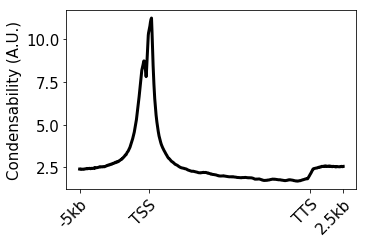

(1, 'mCD8T:DFMO', 'H3K27me3')


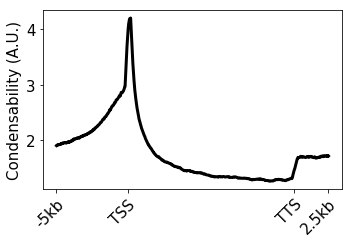

(1, 'mCD8T:DFMO', 'dH3K27ac')


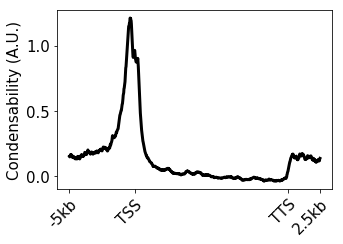

(1, 'mCD8T:DFMO', 'dH3K27me3')


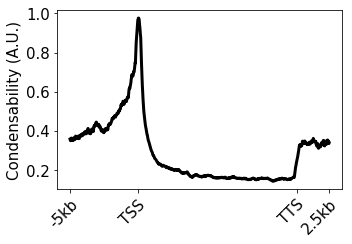

(1, 'mCD8T:DFMO', 'dscore')


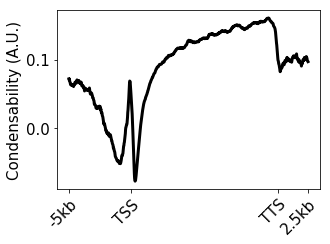

(1, 'mCD8T:DFMO', 'dzscore')


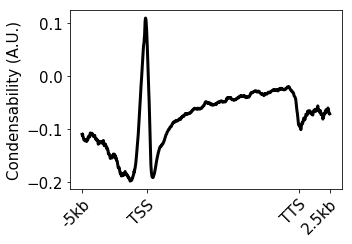

(1, 'mCD8T:DFMO', 'score')


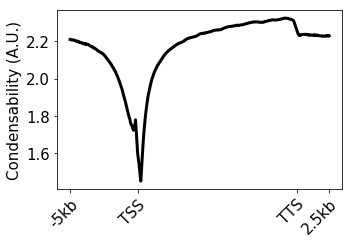

(1, 'mCD8T:DFMO', 'zscore')


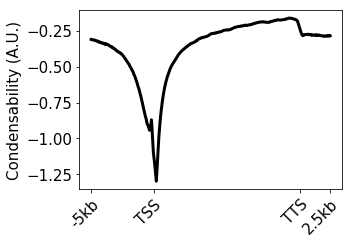

(1, 'mCD8T:WT', 'H3K27ac')


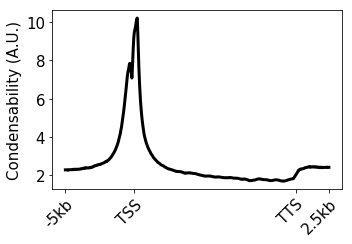

(1, 'mCD8T:WT', 'H3K27me3')


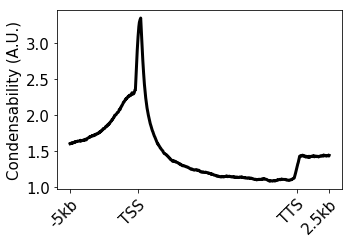

(1, 'mCD8T:WT', 'score')


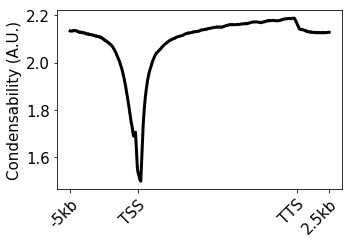

(1, 'mCD8T:WT', 'zscore')


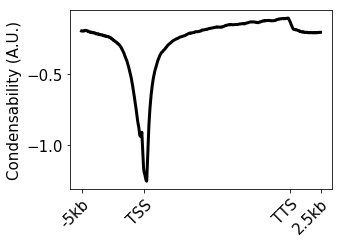

(2, 'mCD8T:DFMO', 'H3K27ac')


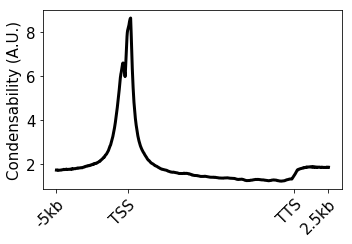

(2, 'mCD8T:DFMO', 'H3K27me3')


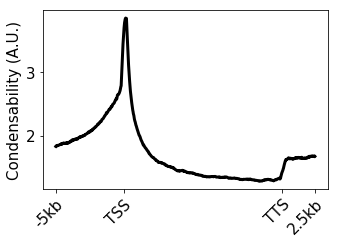

(2, 'mCD8T:DFMO', 'dH3K27ac')


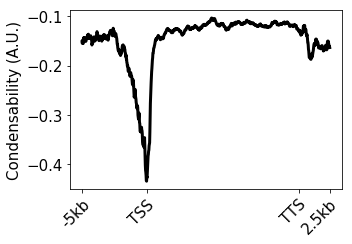

(2, 'mCD8T:DFMO', 'dH3K27me3')


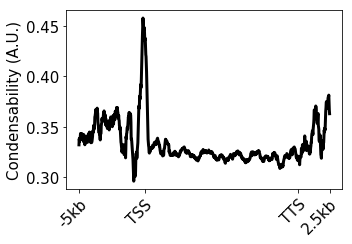

(2, 'mCD8T:WT', 'H3K27ac')


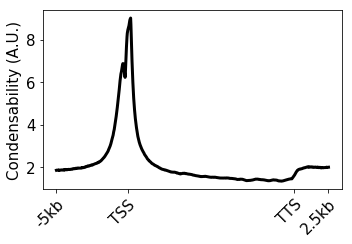

(2, 'mCD8T:WT', 'H3K27me3')


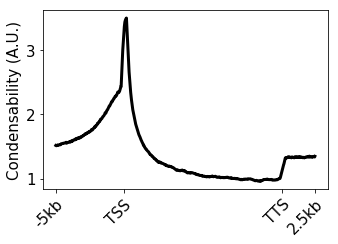

(3, 'mCD8T:DFMO', 'H3K27ac')


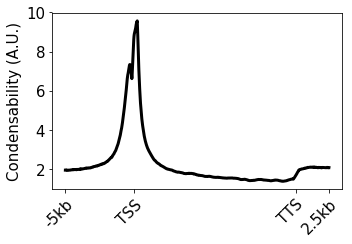

(3, 'mCD8T:DFMO', 'H3K27me3')


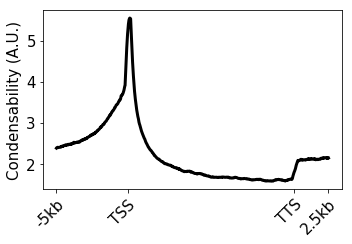

(3, 'mCD8T:DFMO', 'dH3K27ac')


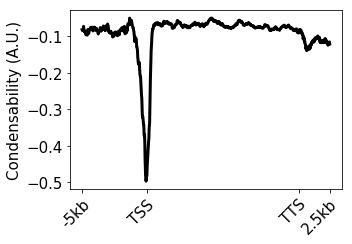

(3, 'mCD8T:DFMO', 'dH3K27me3')


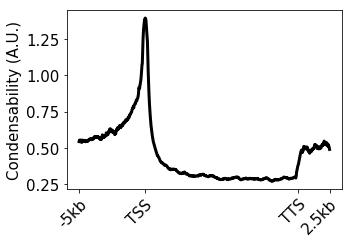

(3, 'mCD8T:WT', 'H3K27ac')


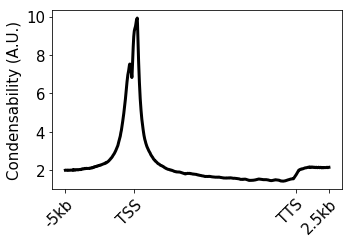

(3, 'mCD8T:WT', 'H3K27me3')


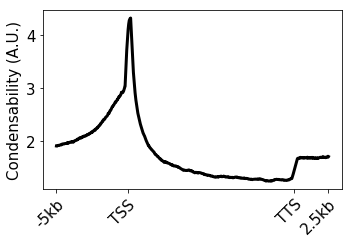

1

In [15]:
# plot mean profile
for dkey in sorted(dkey_geneID_profile):
    print dkey
    geneID_profile = dkey_geneID_profile[dkey]
    mprofile = np.nanmean(geneID_profile.values(), axis=0)
    mprofile = statis.moving_average(mprofile, 20)

    param = domain_param['TSS-TTS']

    graphics.plot_profile (mprofile,
                           offset=param['offset'],
                           pad_len=param['pad_len'],
                           xtick_locs=param['xtick_locs'],
                           xtick_labels=param['xtick_labels'],
                           ylabel='Condensability (A.U.)')
                           
1                           

In [27]:
# partition quantiles according to delta score near TSS
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
metric_dkey = (1, 'mCD8T:DFMO', 'dscore')
for dkey in sorted(dkey_geneID_profile):
    print dkey
    geneID_profile = dkey_geneID_profile[dkey]
    geneID_metric = dkey_geneID_metric[metric_dkey]
    geneIDs = set(geneID_profile.keys()) & set(geneID_metric.keys())
    q_geneIDs = statis.quantile_dict(geneID_metric, 5, IDs=geneIDs)
    
    profiles = []
    labels = []
    for i in range(len(q_geneIDs)):
        profile = np.nanmean([geneID_profile[geneID] for geneID in q_geneIDs[i]], axis=0)
        profile = statis.moving_average(profile, 20)
        profiles.append(profile)
        labels.append('$\Delta$score Q%d' % (i+1))
        
    graphics.plot_profile_multiple (profiles,
                                    colors=colors,
                                    alphas=[1]*len(profiles),
                                    lws=[3]*len(profiles),
                                    labels=labels,
                                    offset=param['offset'],
                                    pad_len=param['pad_len'],
                                    xtick_locs=param['xtick_locs'],
                                    xtick_labels=param['xtick_labels'],
                                    ylabel='read counts',
                                    title='%s %s %s' % dkey,
                                    fig_width=5,
                                    fig_height=4,
                                    save=True,
                                    note='%s %s %s' % dkey)
    print
    print
        
    

(1, 'mCD8T:DFMO', 'H3K27ac')




(1, 'mCD8T:DFMO', 'H3K27me3')




(1, 'mCD8T:DFMO', 'dH3K27ac')




(1, 'mCD8T:DFMO', 'dH3K27me3')




(1, 'mCD8T:DFMO', 'dscore')




(1, 'mCD8T:DFMO', 'dzscore')




(1, 'mCD8T:DFMO', 'score')




(1, 'mCD8T:DFMO', 'zscore')




(1, 'mCD8T:WT', 'H3K27ac')




(1, 'mCD8T:WT', 'H3K27me3')




(1, 'mCD8T:WT', 'score')




(1, 'mCD8T:WT', 'zscore')




(2, 'mCD8T:DFMO', 'H3K27ac')




(2, 'mCD8T:DFMO', 'H3K27me3')




(2, 'mCD8T:DFMO', 'dH3K27ac')




(2, 'mCD8T:DFMO', 'dH3K27me3')




(2, 'mCD8T:WT', 'H3K27ac')




(2, 'mCD8T:WT', 'H3K27me3')




(3, 'mCD8T:DFMO', 'H3K27ac')




(3, 'mCD8T:DFMO', 'H3K27me3')




(3, 'mCD8T:DFMO', 'dH3K27ac')




(3, 'mCD8T:DFMO', 'dH3K27me3')




(3, 'mCD8T:WT', 'H3K27ac')




(3, 'mCD8T:WT', 'H3K27me3')


In [28]:
# partition quantiles according to delta zscore near TSS
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
metric_dkey = (1, 'mCD8T:DFMO', 'dzscore')
for dkey in sorted(dkey_geneID_profile):
    print dkey
    geneID_profile = dkey_geneID_profile[dkey]
    geneID_metric = dkey_geneID_metric[metric_dkey]
    geneIDs = set(geneID_profile.keys()) & set(geneID_metric.keys())
    q_geneIDs = statis.quantile_dict(geneID_metric, 5, IDs=geneIDs)
    
    profiles = []
    labels = []
    for i in range(len(q_geneIDs)):
        profile = np.nanmean([geneID_profile[geneID] for geneID in q_geneIDs[i]], axis=0)
        profile = statis.moving_average(profile, 20)
        profiles.append(profile)
        labels.append('$\Delta$z-score Q%d' % (i+1))
        
    graphics.plot_profile_multiple (profiles,
                                    colors=colors,
                                    alphas=[1]*len(profiles),
                                    lws=[3]*len(profiles),
                                    labels=labels,
                                    offset=param['offset'],
                                    pad_len=param['pad_len'],
                                    xtick_locs=param['xtick_locs'],
                                    xtick_labels=param['xtick_labels'],
                                    ylabel='read counts',
                                    title='%s %s %s' % dkey,
                                    fig_width=5,
                                    fig_height=4,
                                    save=True,
                                    note='%s %s %s' % dkey)
    print
    print

(1, 'mCD8T:DFMO', 'H3K27ac')




(1, 'mCD8T:DFMO', 'H3K27me3')




(1, 'mCD8T:DFMO', 'dH3K27ac')




(1, 'mCD8T:DFMO', 'dH3K27me3')




(1, 'mCD8T:DFMO', 'dscore')




(1, 'mCD8T:DFMO', 'dzscore')




(1, 'mCD8T:DFMO', 'score')




(1, 'mCD8T:DFMO', 'zscore')




(1, 'mCD8T:WT', 'H3K27ac')




(1, 'mCD8T:WT', 'H3K27me3')




(1, 'mCD8T:WT', 'score')




(1, 'mCD8T:WT', 'zscore')




(2, 'mCD8T:DFMO', 'H3K27ac')




(2, 'mCD8T:DFMO', 'H3K27me3')




(2, 'mCD8T:DFMO', 'dH3K27ac')




(2, 'mCD8T:DFMO', 'dH3K27me3')




(2, 'mCD8T:WT', 'H3K27ac')




(2, 'mCD8T:WT', 'H3K27me3')




(3, 'mCD8T:DFMO', 'H3K27ac')




(3, 'mCD8T:DFMO', 'H3K27me3')




(3, 'mCD8T:DFMO', 'dH3K27ac')




(3, 'mCD8T:DFMO', 'dH3K27me3')




(3, 'mCD8T:WT', 'H3K27ac')




(3, 'mCD8T:WT', 'H3K27me3')


In [18]:
# plot profile heatmap
for dkey in dkey_geneID_profile:
    geneID_profile = dkey_geneID_profile[dkey]
    FPKM_geneID = sorted([(geneID_FPKM[geneID], geneID) for geneID in geneID_profile])
    geneIDs = [geneID for FPKM, geneID in FPKM_geneID]
    profiles = []
    for geneID in geneIDs:
        profile = geneID_profile[geneID]
        profile = statis.moving_average(profile, 20)
        profiles.append(profile)

    graphics.plot_profile_heatmap (profiles,
                                   offset=param['offset'],
                                   pad_len=param['pad_len'],
                                   xtick_locs=param['xtick_locs'],
                                   xtick_labels=param['xtick_labels'])

                          


KeyError: 'ENSMUSG00000028184'